*  **Goal:** Getting the diameter of an asteroid from the other data given about that asteroid, in other words supervised regression with the target being $\log(diameter)$.   
The metric used during testing will be the $R^2$ score.
* **How:**
    * Step 1: Cleaning and preparing the data
        * a. I cleared the samples with nan diameter.
        * b. The dataframe had a lot of nan values, I chose to substitute them with the average value for the corresponding feature.
        * c. Diameter and "neo" and "pha" features where encoded in strings so I had to convert them to int for the regression.
    * Step 2: Train-test splitting of the data, and then normalizing (standard) using the test dataframe. 
    * Step 3: Trying different regression algorithms (Linear Regression, Elastic Net, Decision Tree, Random Forest, XGBoost, SVM, Neural Network) and picking the best one.
* **Extra:**  Since some features had a very high correlation with $\log(diameter)$ I removed the features who had a Pearson $R$ coefficient $|R|>0.5$ for the added challenge and curiosity.


**Dependencies: numpy, pandas, matplotlib, seaborn, scikit-learn, xgboost, keras.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Part I: Importing, exploration & cleaning of the data

In [2]:
#Importing only the first 30000 rows
#Data found here: https://www.kaggle.com/basu369victor/prediction-of-asteroid-diameter
df = pd.read_csv('Asteroid.csv',nrows = 30000)

In [3]:
df.head()

,full_name,a,e,G,i,om,w,q,ad,per_y,...,rot_per,GM,BV,UB,IR,spec_B,spec_T,neo,pha,moid
0,1 Ceres,2.769165,0.076009,0.12,10.594067,80.305532,73.597694,2.558684,2.979647,4.608202,...,9.074170,62.6284,0.713,0.426,NaN,C,G,N,N,1.59478
1,2 Pallas,2.772466,0.230337,0.11,34.836234,173.080063,310.048857,2.133865,3.411067,4.616444,...,7.813200,14.3000,0.635,0.284,NaN,B,B,N,N,1.23324
2,3 Juno,2.669150,0.256942,0.32,12.988919,169.852760,248.138626,1.983332,3.354967,4.360814,...,7.210000,NaN,0.824,0.433,NaN,Sk,S,N,N,1.03454
3,4 Vesta,2.361418,0.088721,0.32,7.141771,103.810804,150.728541,2.151909,2.570926,3.628837,...,5.342128,17.8000,0.782,0.492,NaN,V,V,N,N,1.13948
4,5 Astraea,2.574249,0.191095,NaN,5.366988,141.576604,358.687608,2.082324,3.066174,4.130323,...,16.806000,NaN,0.826,0.411,NaN,S,S,N,N,1.09589


**There are lots of feature columns to check:**   
First I wanted to know if there are NaN values (there are and will be dealt with later)

In [4]:
#Checking which columns(features) have nan values
for column in df.columns:
    print(column, df[column].isnull().values.any())

full_name False
a False
e False
G True
i False
om False
w False
q False
ad False
per_y False
data_arc False
condition_code False
n_obs_used False
H False
diameter True
extent True
albedo True
rot_per True
GM True
BV True
UB True
IR True
spec_B True
spec_T True
neo False
pha False
moid False


Next thing is to understand what type of data we're dealing with

In [5]:
#Printing the first ten unique values of each feature
for column in df.columns:
    print(column, df[column].unique()[:10])

full_name ['     1 Ceres' '     2 Pallas' '     3 Juno' '     4 Vesta'
 '     5 Astraea' '     6 Hebe' '     7 Iris' '     8 Flora'
 '     9 Metis' '    10 Hygiea']
a [2.76916515 2.77246592 2.66914952 2.3614179  2.57424892 2.42515999
 2.38533381 2.20176419 2.38563654 3.14153918]
e [0.07600903 0.23033682 0.25694232 0.08872146 0.19109452 0.20300711
 0.23120579 0.15649925 0.12311427 0.11246066]
G [0.12 0.11 0.32  nan 0.24 0.28 0.17 0.22 0.23 0.2 ]
i [10.59406704 34.83623442 12.98891913  7.14177081  5.36698794 14.7379011
  5.52365139  5.88695456  5.57681551  3.83156003]
om [ 80.30553157 173.08006275 169.85275981 103.81080443 141.57660421
 138.64020276 259.56323069 110.88932989  68.9085767  283.20216686]
w [ 73.59769412 310.04885743 248.13862618 150.72854129 358.68760779
 239.80749023 145.26510583 285.28746222   6.41736923 312.31520625]
q [2.5586836  2.13386493 1.98333205 2.15190945 2.08232406 1.93283527
 1.83383082 1.85718974 2.09193063 2.78823962]
ad [2.97964671 3.41106691 3.35496699 2.57

* **Cleaning and prepping the dataframe:**  
**Steps:**
    * 0/ 'diameter' is string type, I will convert to numeric. This gave errors for some diameters because they were corrupted, so I added the argument "errors='coerce'" to set corrupted diameters to nan, and later dropped those.
    * 1/ Dropping irrelevent features and choosing my battles:
        * 1a/ IR is full of nans so I will drop it
        * 1b/ I will drop full name too as I dont believe asteroids are named according to their diameter
        * 1c/ 'extent' is also string type but 3d_types, since I suspect its the asteroid dimentions I will drop it
        * 1d/ dropping condition_code too because most seems to be 0 or nan.
        * 1e/ spec_B and spec_T might be interesting but I choose to drop them because we already have a lot to deal with. One way to take advantage of those values would be to use one-hot encoding but this would add around 50 features columns. 
    * 2/ Transform neo and pha (Y,N) string type values to (True,False) bool(binary int) values
    * 3/ Replace nans entries with mean value of column

In [6]:
#Steps 0
df['diameter']=pd.to_numeric(df['diameter'],errors='coerce') #transforming to numeric, setting errors to NaN
dropindexes = df['diameter'][df['diameter'].isnull()].index #rows with nan diameters to drop
dropped_df = df.loc[dropindexes] #saving dropped rows for the future
df = df.drop(dropindexes, axis=0) 

In [7]:
#Steps 1
df = df.drop(['condition_code','full_name','IR','spec_B','spec_T','extent'],axis=1)

In [8]:
#Step 2
df = df.replace({'neo': {'Y': True, 'N': False}})
df = df.replace({'pha': {'Y': True, 'N': False}})

In [9]:
#Step 3
df = df.fillna(df.mean())

In [10]:
df.head()

,a,e,G,i,om,w,q,ad,per_y,data_arc,...,H,diameter,albedo,rot_per,GM,BV,UB,neo,pha,moid
0,2.769165,0.076009,0.120000,10.594067,80.305532,73.597694,2.558684,2.979647,4.608202,8822,...,3.34,939.400,0.0900,9.074170,62.62840,0.713,0.426,False,False,1.59478
1,2.772466,0.230337,0.110000,34.836234,173.080063,310.048857,2.133865,3.411067,4.616444,72318,...,4.13,545.000,0.1010,7.813200,14.30000,0.635,0.284,False,False,1.23324
2,2.669150,0.256942,0.320000,12.988919,169.852760,248.138626,1.983332,3.354967,4.360814,72684,...,5.33,246.596,0.2140,7.210000,9.81609,0.824,0.433,False,False,1.03454
3,2.361418,0.088721,0.320000,7.141771,103.810804,150.728541,2.151909,2.570926,3.628837,24288,...,3.20,525.400,0.4228,5.342128,17.80000,0.782,0.492,False,False,1.13948
4,2.574249,0.191095,0.186579,5.366988,141.576604,358.687608,2.082324,3.066174,4.130323,63431,...,6.85,106.699,0.2740,16.806000,9.81609,0.826,0.411,False,False,1.09589


In [11]:
#Last sanity check for nan values
df.isna().values.any()

False

Since a lot of values in physics are more relevant when you consider their log, I'll add columns to the dataframe corresponding to the log of the original columns:

In [12]:
df['diameter']= df['diameter'].apply(np.log)
for column in df.columns.drop(['diameter','neo','pha']):
    df['log('+column+')']=df[column].apply(np.log)
df = df.dropna(axis=1)

Correlation analysis:

In [13]:
df.corr()['diameter'].abs().sort_values(ascending=False)

diameter           1.000000
H                  0.906135
log(H)             0.896375
log(albedo)        0.629475
log(per_y)         0.622497
log(a)             0.622497
log(ad)            0.605441
data_arc           0.583459
albedo             0.579702
log(q)             0.533683
n_obs_used         0.526710
log(data_arc)      0.522696
log(moid)          0.504905
a                  0.500553
log(n_obs_used)    0.483892
moid               0.477567
ad                 0.476470
q                  0.473422
per_y              0.316803
i                  0.255413
log(i)             0.211454
log(UB)            0.128233
log(BV)            0.128004
neo                0.119973
log(rot_per)       0.117464
BV                 0.104449
pha                0.089169
UB                 0.079716
log(e)             0.059763
e                  0.055441
GM                 0.028507
log(GM)            0.007384
rot_per            0.006152
w                  0.004292
log(w)             0.004283
G                  0

Nasa's own Asteroid Size Estimator website uses the $H$ value and $\log(albedo)$: https://cneos.jpl.nasa.gov/tools/ast_size_est.html

Optional: Removing columns that give too high correlation for curiosity / added difficulty:

In [14]:
### Optional : removing columns that give too high correlation(|R|>.5) for curiosity

#Identifing columns to drop and dropping them
tooHighCorr = df.columns[(df.corr()['diameter'].abs()  > 0.5)]
df = df.drop(tooHighCorr.drop('diameter'),axis=1)

#checking the effect
df.corr()['diameter'].abs().sort_values(ascending=False).head()

diameter           1.000000
log(n_obs_used)    0.483892
moid               0.477567
ad                 0.476470
q                  0.473422
Name: diameter, dtype: float64

## Part II: Splitting the dataframe into train and test dataframes and normalizing them for our regressions.

Splitting:

In [15]:
from sklearn.model_selection import train_test_split
predictors = df.drop('diameter',axis=1) 
target = df['diameter']
X_train,X_test,Y_train,Y_test = train_test_split(predictors,target,test_size=0.20,random_state=0)

In [16]:
X_train.head()

,e,G,i,om,w,q,ad,per_y,rot_per,GM,...,moid,log(e),log(i),log(om),log(w),log(n_obs_used),log(rot_per),log(GM),log(BV),log(UB)
11845,0.121263,0.186579,4.666368,92.991153,341.723870,2.226844,2.841441,4.034175,23.750645,9.81609,...,1.242370,-2.109792,1.540381,4.532504,5.834003,7.545390,3.167610,2.284023,-0.262749,-1.009424
931,0.090319,0.186579,8.113072,14.973032,49.782882,2.201650,2.638838,3.765277,78.440000,9.81609,...,1.223030,-2.404408,2.093477,2.706251,3.907671,7.748029,4.362334,2.284023,-0.396010,-1.114742
4617,0.292301,0.186579,11.473600,342.891153,61.760667,1.859502,3.395561,4.259220,23.750645,9.81609,...,0.897468,-1.229972,2.440049,5.837413,4.123267,7.146772,3.167610,2.284023,-0.262749,-1.009424
2290,0.065147,0.186579,24.491739,169.492215,296.486266,2.845355,3.241924,5.310043,9.630000,9.81609,...,1.919340,-2.731107,3.198336,5.132807,5.692001,7.681099,2.264883,2.284023,-0.262749,-1.009424
27554,0.061422,0.186579,10.541331,52.202468,85.381958,2.882874,3.260194,5.383208,23.750645,9.81609,...,1.921900,-2.789985,2.355304,3.955130,4.447135,6.818924,3.167610,2.284023,-0.262749,-1.009424


Normalization:

In [17]:
from sklearn import preprocessing

#Input standard normalization:
std_scaler = preprocessing.StandardScaler().fit(X_train)

def scaler(X):
    x_norm_arr= std_scaler.fit_transform(X)
    return pd.DataFrame(x_norm_arr, columns=X.columns)

X_train_norm = scaler(X_train)
X_test_norm = scaler(X_test)

def inverse_scaler(X):
    x_norm_arr= std_scaler.inverse_transform(X)
    return pd.DataFrame(x_norm_arr, columns=X.columns)

#Output standard normalization:
Y_std_scaler = preprocessing.StandardScaler().fit(Y_train.values.reshape(-1,1))

def Y_scaler(X):
    x_norm_arr= Y_std_scaler.fit_transform(X)
    return pd.DataFrame(x_norm_arr)


def Y_inverse_scaler(X):
    x_norm_arr= Y_std_scaler.inverse_transform(X)
    return pd.DataFrame(x_norm_arr)

Y_train_norm = Y_scaler(Y_train.values.reshape(-1,1))
Y_test_norm = Y_scaler (Y_test.values.reshape(-1,1))

## Part III:  Trying different regressions and ranking them according to their $R^2$ score.
**Algorithms used:** Linear Regression, Elastic Net, k-Nearest Neighbours, Decision Tree, Random Forest, SVM, Neural Network and XGBoost. 

In [18]:
from sklearn.metrics import r2_score
import seaborn as sns

def plot(prediction):
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,7)) 
    sns.distplot(Y_test_norm.values,label='test values', ax=ax1)
    sns.distplot(prediction ,label='prediction', ax=ax1)
    ax1.set_xlabel('Distribution plot')
    ax2.scatter(Y_test_norm,prediction, c='orange',label='predictions')
    ax2.plot(Y_test_norm,Y_test_norm,c='blue',label='y=x')
    ax2.set_xlabel('test value')
    ax2.set_ylabel('estimated $\log(radius)$')
    ax1.legend()
    ax2.legend()
    ax2.axis('scaled') #same x y scale
def score(prediction):
    score = r2_score(prediction,Y_test_norm)
    return score
def announce(score):
    print('The R^2 score achieved using this regression is:', round(score,3))
algorithms = []
scores = []


Linear Regression:

In [19]:
#Defining the model
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

###Training
lr.fit(X_train_norm,Y_train_norm)

###Predicting
Y_pred_lr = lr.predict(X_test_norm)

###Scoring
score_lr = score(Y_pred_lr)
announce(score_lr)

algorithms.append('LR')
scores.append(score_lr)


The R^2 score achieved using this regression is: 0.521


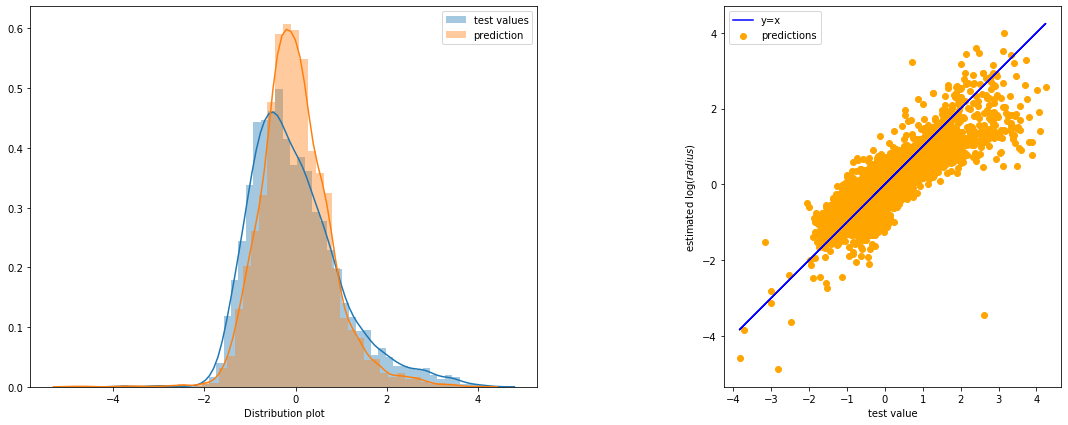

In [20]:
plot(Y_pred_lr)

Elastic Net regression:

In [21]:
### Defining the Model
from sklearn.linear_model import ElasticNetCV
enet = ElasticNetCV(cv=16, random_state = 0)

### Training
enet.fit(X_train,np.ravel(Y_train_norm))

### Predicting
Y_pred_enet = enet.predict(X_test)

###Scoring
score_enet = score(Y_pred_enet)
announce(score_enet)

algorithms.append('eNet')
scores.append(score_enet)

The R^2 score achieved using this regression is: 0.535


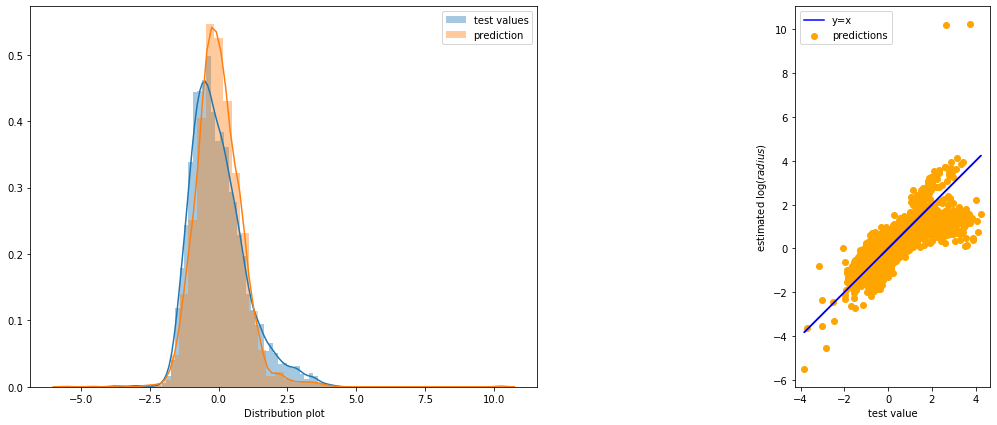

In [22]:
plot(Y_pred_enet)

k-Nearest Neighbours regression:

In [23]:
### Defining the Model
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=5)

### Training
neigh.fit(X_train_norm,Y_train_norm)

### Predicting 
Y_pred_neigh = neigh.predict(X_test_norm)

### Scoring
score_neigh=score(Y_pred_neigh)
announce(score_neigh)

algorithms.append('k-NN')
scores.append(score_neigh)

The R^2 score achieved using this regression is: 0.727


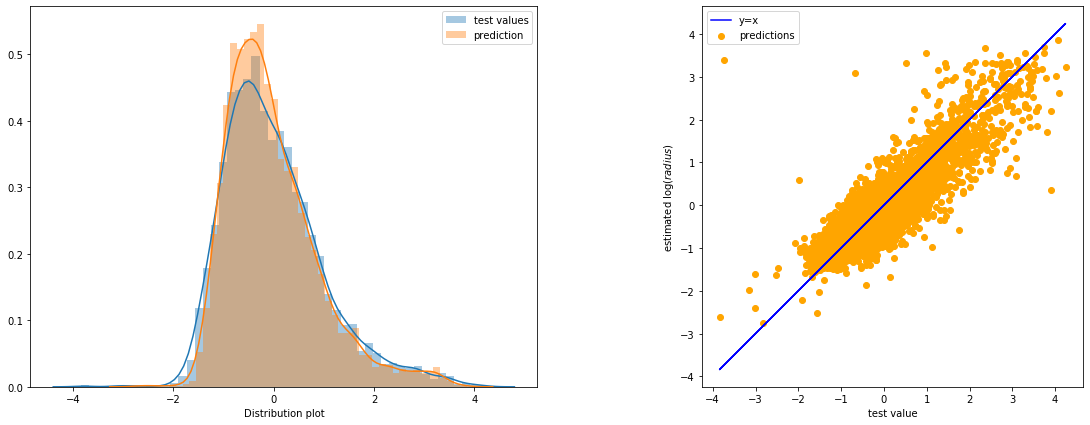

In [24]:
plot(Y_pred_neigh)

Decision Tree regression:

In [25]:
### Defining the model
from sklearn import tree
decTree = tree.DecisionTreeRegressor()

### Training
decTree = decTree.fit(X_train_norm,Y_train_norm)

### Predicting
Y_pred_tree = decTree.predict(X_test_norm)

### Scoring
score_tree = score(Y_pred_tree)
announce(score_tree)

algorithms.append('DTree')
scores.append(score_tree)

The R^2 score achieved using this regression is: 0.654


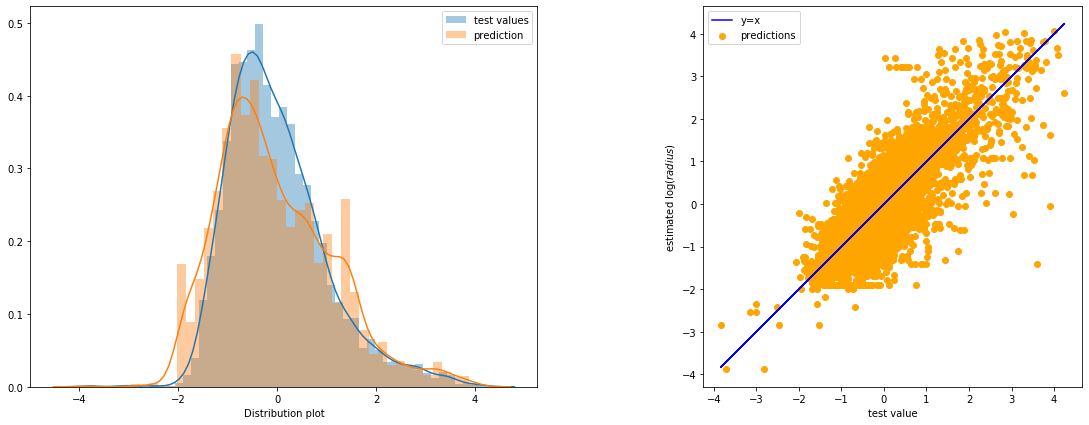

In [26]:
plot(Y_pred_tree)

Random Forest regression:

In [27]:
### Defining the model
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(max_depth=32, n_estimators=50)

### Training 
forest.fit(X_train_norm,np.ravel(Y_train_norm))

###Predicting
Y_pred_forest = forest.predict(X_test_norm)

### Scoring
score_forest = score(Y_pred_forest)
announce(score_forest)

algorithms.append('RForest')
scores.append(score_forest)

The R^2 score achieved using this regression is: 0.782


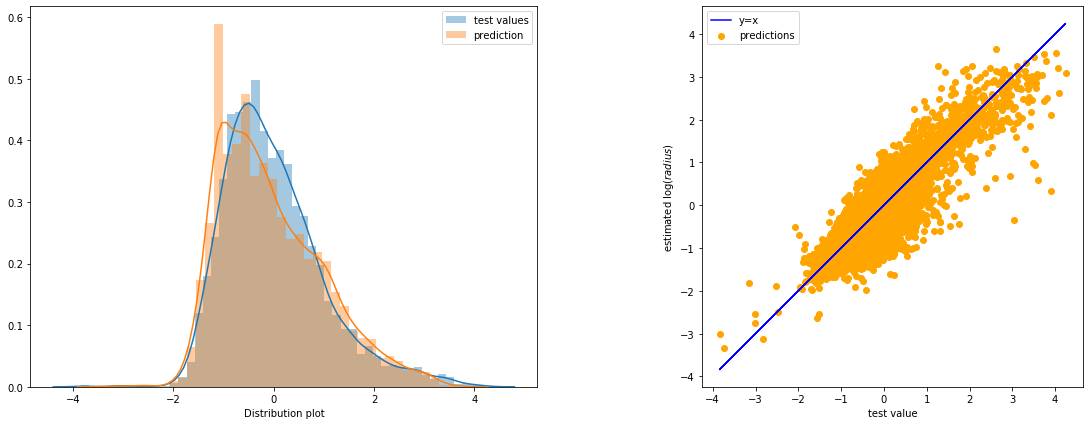

In [28]:
plot(Y_pred_forest)

Support Vector Machine regression:

In [29]:
### Defining the model
from sklearn import svm
svmreg = svm.SVR()

### Training
svmreg.fit(X_train_norm,np.ravel(Y_train_norm))

### Predicting
Y_pred_svm = svmreg.predict(X_test_norm)

### Scoring
score_svm = score(Y_pred_svm)
announce(score_svm)

algorithms.append('SVM')
scores.append(score_svm)

The R^2 score achieved using this regression is: 0.775


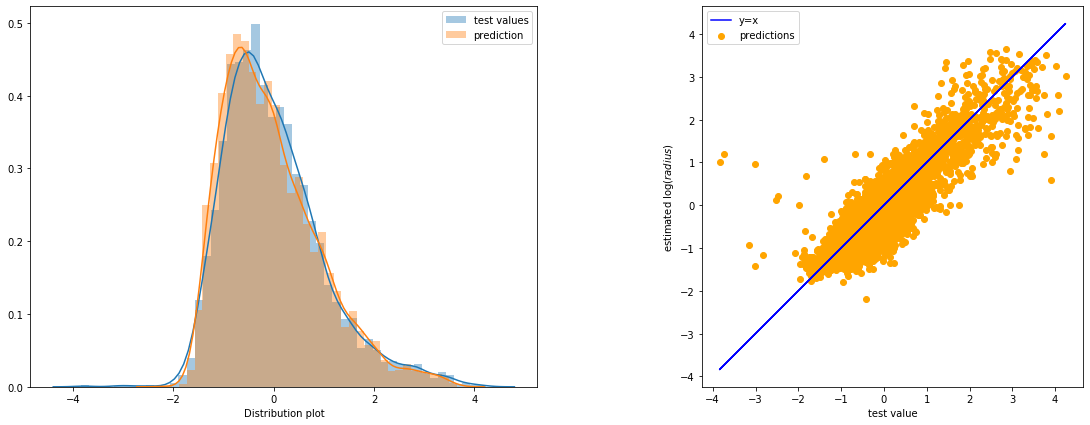

In [30]:
plot(Y_pred_svm)

Neural Network regression:

In [31]:
### Defining the model
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam

Adam(learning_rate=0.005)
model = Sequential()
model.add(Dense(24,activation='tanh',input_dim=X_train_norm.shape[1]))
model.add(Dense(12,activation='tanh'))
model.add(Dense(1))

model.compile(loss='mean_squared_error',optimizer='adam')

### Training

model.fit(X_train_norm,Y_train_norm,epochs=100,batch_size=256,verbose=False)

### Predicting

Y_pred_nn = model.predict(X_test_norm)

### Scoring
score_nn = score(Y_pred_nn)
announce(score_nn)

algorithms.append('NNet')
scores.append(score_nn)

Using TensorFlow backend.


The R^2 score achieved using this regression is: 0.807


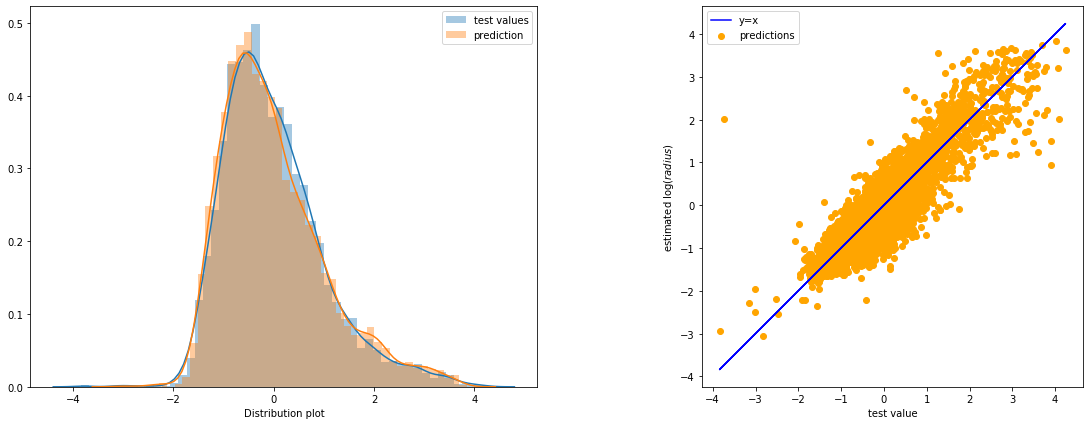

In [32]:
plot(Y_pred_nn)

XGBoost regression:

In [33]:
### Defining the model
import xgboost as xgb 
xgReg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, 
                         learning_rate = 0.08 ,
                max_depth = 4, n_estimators = 500)

### Training
xgReg.fit(X_train_norm,Y_train_norm)

### Predicting
Y_pred_xgb = xgReg.predict(X_test_norm)

### Scoring
score_xgb = score(Y_pred_xgb)
announce(score_xgb)

algorithms.append('XGB')
scores.append(score_xgb)

The R^2 score achieved using this regression is: 0.799


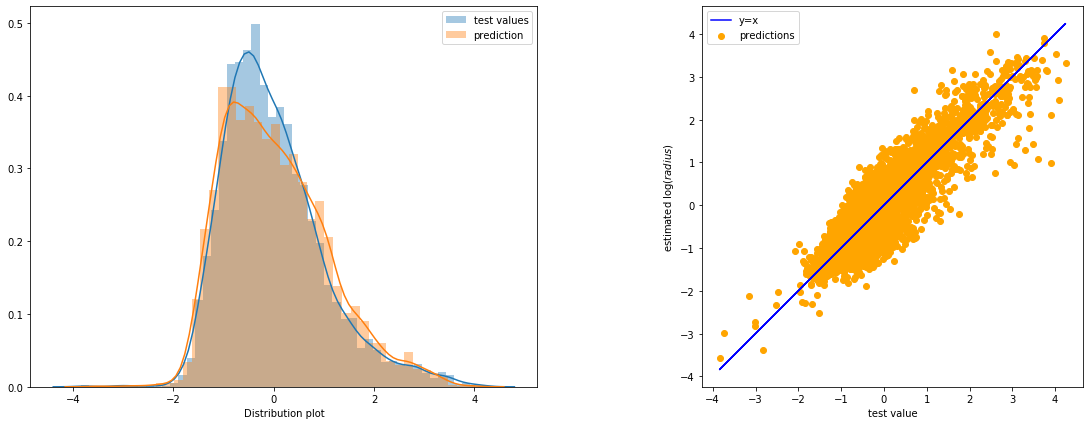

In [34]:
plot(Y_pred_xgb)

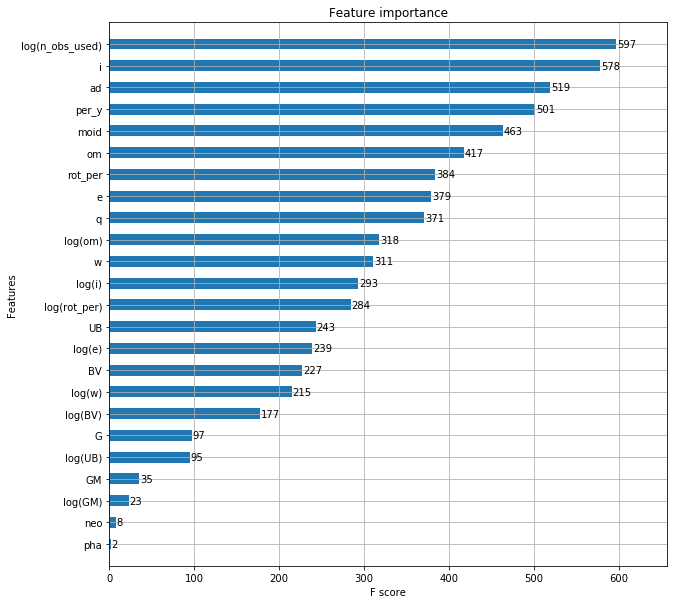

In [35]:
# One bonus of using xgboost is being able to 
# simply see how important the different features where when creating the learners.

fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(xgReg, height=0.5, ax=ax, importance_type='weight')
plt.show()

Comparing all regression algorithms

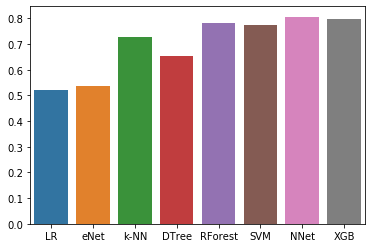

In [36]:
sns.barplot(algorithms,scores)

Neural Networks win today with an $R^2$ score of 0.807

Thank you for reading !